# Analyse the quantile values of AGCD precipitation data

In [45]:
import os, sys
import glob
import xarray as xr
import numpy as np
workdir = "/g/data/hd50/chs548/BARRA2_evaluation/chs/icclim/"
os.chdir(workdir)
sys.path.append("/g/data/tp28/dev/chs548/BARPA_evaluation/lib")
import lib_standards
import lib_spatial
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm

## Compute quantiles

In [2]:
files = glob.glob('/g/data/xv83/agcd-csiro/precip/daily/precip-*.nc')

In [3]:
files_only = []
start_year = 1985
end_year = 2014
for file in files:
    year = int(os.path.basename(file).split('_')[3][:4])
    if year >= start_year and year <= end_year:
        files_only.append(file)
files_only.sort()

In [4]:
ds = xr.open_mfdataset(files_only)

In [5]:
ds_chunk = ds.chunk(dict(time=-1))

In [6]:
qs = [0.90, 0.95, 0.98, 0.99, 0.999, 0.9999]
quantiles = ds_chunk.quantile(qs, dim='time').compute()

In [13]:
quantiles.to_netcdf('/g/data/hd50/chs548/barra2_shared_dev/added_value/agcd_precip_quantiles.%d_%d.nc' % (start_year, end_year))

## Plot the results

In [3]:
ds = xr.open_dataset('agcd_precip_quantiles.1985_2014.nc')

In [24]:
qs = ds['quantile'].values
regions = lib_spatial.get_nrm_names()

q=0.900, region=Southern Slopes, quantile mean=8.08, median=6.51, min=3.35, max=26.49
q=0.900, region=Murray Basin, quantile mean=3.63, median=2.93, min=0.95, max=18.28
q=0.900, region=Southern and South Western Flatlands, quantile mean=3.29, median=2.67, min=0.82, max=10.99
q=0.900, region=Central Slopes, quantile mean=4.18, median=3.93, min=1.83, max=9.36
q=0.900, region=East Coast, quantile mean=5.77, median=5.05, min=2.75, max=15.50
q=0.900, region=Rangelands, quantile mean=1.08, median=0.96, min=0.00, max=5.85
q=0.900, region=Monsoonal North, quantile mean=5.67, median=5.12, min=0.10, max=20.06
q=0.900, region=Wet Tropics, quantile mean=12.07, median=11.39, min=3.80, max=33.06

q=0.950, region=Southern Slopes, quantile mean=13.30, median=11.92, min=6.48, max=34.90
q=0.950, region=Murray Basin, quantile mean=7.58, median=6.57, min=3.03, max=31.38
q=0.950, region=Southern and South Western Flatlands, quantile mean=6.66, median=5.66, min=2.98, max=18.14
q=0.950, region=Central Slopes

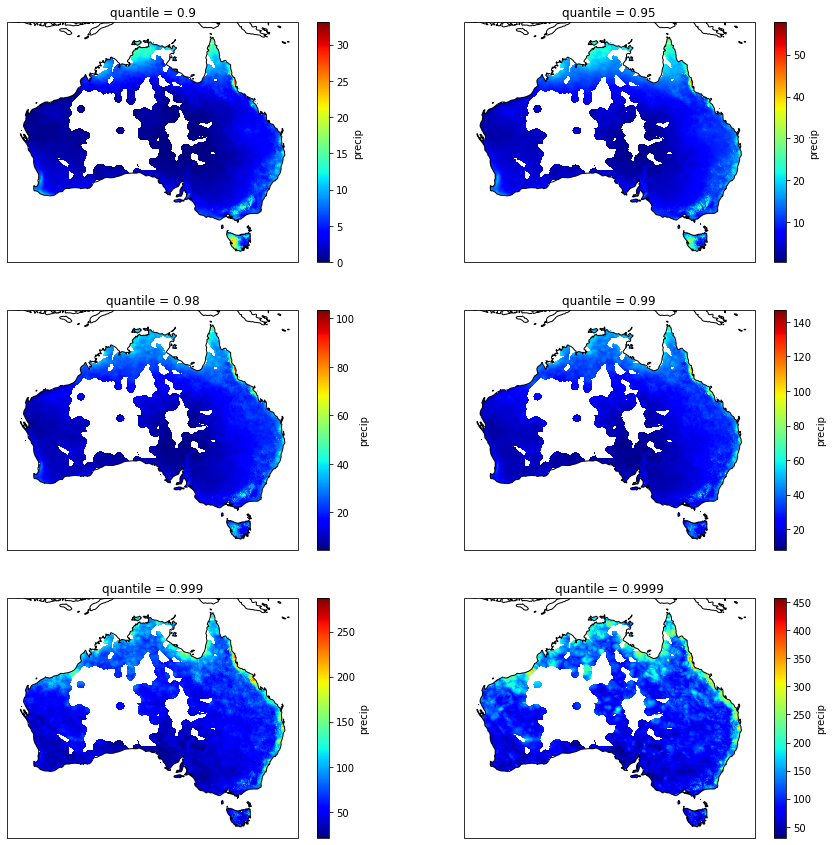

In [46]:
fig = plt.figure(figsize=(15,15))
for i, q in enumerate(qs):
    ds0 = ds.sel(quantile=q)
    ds0 = lib_spatial.apply_region_mask(ds0, 'Australia')
    ds0 = lib_spatial.apply_agcd_data_mask(ds0)
    
    ax = plt.subplot(3,2,i+1, projection=ccrs.PlateCarree())
    ds0['precip'].plot(cmap=cm.jet)
    ax.coastlines()
    
    for region in regions:
        ds0_region = lib_spatial.apply_region_mask(ds0, region)
        vmean = float(ds0_region['precip'].mean())
        vmin =  float(ds0_region['precip'].min())
        vmax =  float(ds0_region['precip'].max())
        vmedian = float(ds0_region['precip'].median())
        print("q=%3.3f, region=%s, quantile mean=%3.2f, median=%3.2f, min=%3.2f, max=%3.2f" % (q, region, vmean, vmedian, vmin, vmax))
    print("")

In [50]:
vmeans = {}
vmins = {}
vmaxs = {}
vmedians = {}

for i, q in enumerate(qs):
    ds0 = ds.sel(quantile=q)
    ds0 = lib_spatial.apply_region_mask(ds0, 'Australia')
    ds0 = lib_spatial.apply_agcd_data_mask(ds0)
    
    vmeans[q] = []
    vmins[q] = []
    vmaxs[q] = []
    vmedians[q] = []
    for region in regions:
        ds0_region = lib_spatial.apply_region_mask(ds0, region)
        vmean = float(ds0_region['precip'].mean())
        vmin =  float(ds0_region['precip'].min())
        vmax =  float(ds0_region['precip'].max())
        vmedian = float(ds0_region['precip'].median())
        vmeans[q].append(vmean)
        vmins[q].append(vmin)
        vmaxs[q].append(vmax)
        vmedians[q].append(vmedian)

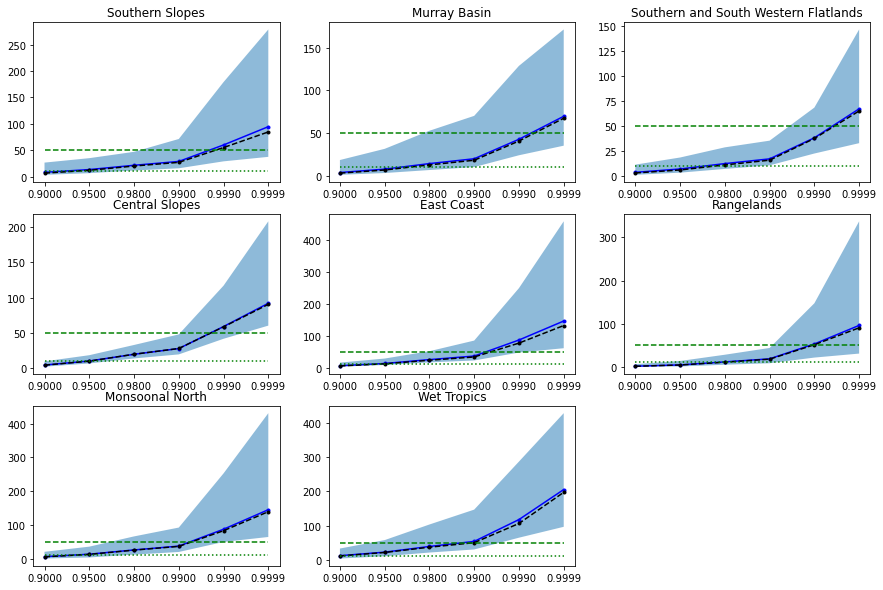

In [77]:
fig = plt.figure(figsize=(15,10))

xs = range(0, len(qs))
for i, region in enumerate(regions):
    ax = plt.subplot(3,3,i+1)
    ax.set_title(region)
    vmax_qs = [vmaxs[q][i] for q in qs]
    vmin_qs = [vmins[q][i] for q in qs]
    vmean_qs = [vmeans[q][i] for q in qs]
    vmedian_qs = [vmedians[q][i] for q in qs]
    ax.fill_between(xs, vmax_qs, vmin_qs, alpha=0.5)
    ax.plot(xs, vmean_qs, '.-b')
    ax.plot(xs, vmedian_qs, '.--k')
    ax.plot([xs[0], xs[-1]], [10, 10], ':g')
    ax.plot([xs[0], xs[-1]], [50, 50], '--g')
    #ax.set_ylim(0, 440)
    ax.set_xticks(xs)
    ax.set_xticklabels(['%3.4f' % q for q in qs])
    